In [93]:
# d for coin futures, f for usd s futures
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import requests as re
import pandas as pd

api = 'https://api.binance.com/api/v3/klines'
g_api_key='eJBYUpKfnUCA5wXDfJTKGPNaOoyLtnXIb9D6GKFbnABLCndVRRYJrdyI9rMi6D54'
g_secret_key='970sbCiGtH1W4rPW56I4MBbD9brKZegyveedljt3U3D5hry7zMbxa4sxacA80kUv'
headers = {"Accept": "application/json"}

epoch = datetime.utcfromtimestamp(0)

def dt_to_ms(dt):
    delta = dt - epoch
    return int(delta.total_seconds() * 1000)

def dt_from_ms(ms):
    return datetime.utcfromtimestamp(ms / 1000.0)

def json_to_df(json):
    df = {'time':[],'open':[],'high':[],'low':[],'close':[],'volume':[]}
    for item in json:
        df['time'].append(dt_from_ms(item[0]))
        df['open'].append(float(item[1]))
        df['high'].append(float(item[2]))
        df['low'].append(float(item[3]))
        df['close'].append(float(item[4]))
        df['volume'].append(float(item[5]))
    return pd.DataFrame(df)

(array([  3.,   6.,  12.,  53., 204., 432., 193.,  52.,  12.,   6.]),
 array([-0.05316816, -0.04327912, -0.03339008, -0.02350104, -0.01361199,
        -0.00372295,  0.00616609,  0.01605513,  0.02594417,  0.03583322,
         0.04572226]),
 <BarContainer object of 10 artists>)

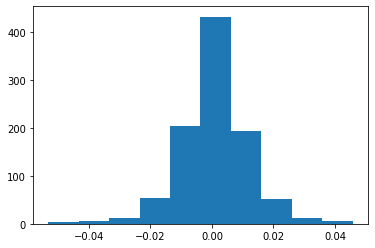

In [118]:
pair = 'ETHUSDT'
interval = '1h'
start_date = '20210401'
end_date = '20210512'
start_year, start_month, start_day = int(start_date[0:4]), int(start_date[4:6]), int(start_date[6:8])
end_year, end_month, end_day = int(end_date[0:4]), int(end_date[4:6]), int(end_date[6:8])
start_date = dt_to_ms(datetime(start_year, start_month, start_day))
end_date = dt_to_ms(datetime(end_year, end_month, end_day))
limit = 1000
url = api + '?symbol='+pair+'&interval='+interval+'&startTime='+str(start_date)+'&limit='+str(limit)
r = re.get(url, headers=headers)
result = r.json()
df = json_to_df(result)
df['return'] = df['close'].pct_change(1)
plt.hist(df['return'].values)

<AxesSubplot:>

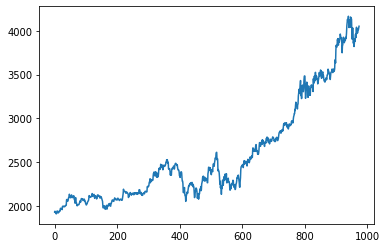

In [119]:
df['close'].plot()

In [120]:
drift = df['return'].dropna().mean()
diffusion = df['return'].dropna().std()
drift * 100
drift=0
diffusion * 100

1.1198552097555583

In [127]:
from numpy.random import normal
import numpy as np
import pandas as pd
import math

def price_simulation(start_value, drift, diffusion, n_periods):
    returns = [1 + (drift + diffusion * normal()) for _ in range(n_periods)]
    prices = [start_value * np.prod(returns[:i]) for i in range(len(returns))]
    return (returns, prices)

def price_simulation_gbm(start_value, drift, diffusion, n_periods):
    prices = []
    for _ in range(n_periods):
        start_value *= math.exp((drift - (diffusion**2) / 2) + diffusion * normal())
        prices.append(start_value)
    return prices

start_value = df.tail(1)['close'].values[0]
n_simulations = 10000
results = []
for _ in range(n_simulations):
    #returns, prices = price_simulation(start_value, drift, diffusion, 168)
    prices = price_simulation_gbm(start_value, drift, diffusion, 24)
    results.append(prices)
terminal_values = [x[-1] for x in results]

(array([  52.,  396., 1281., 2460., 2794., 1851.,  858.,  246.,   54.,
           8.]),
 array([3372.60495982, 3530.14148579, 3687.67801177, 3845.21453774,
        4002.75106372, 4160.28758969, 4317.82411567, 4475.36064164,
        4632.89716762, 4790.43369359, 4947.97021956]),
 <BarContainer object of 10 artists>)

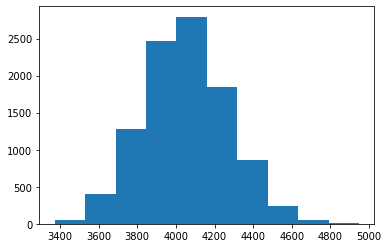

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(terminal_values)

In [129]:
pd.qcut(terminal_values, [0.025, 0.975])

[(3637.819, 4496.935], (3637.819, 4496.935], (3637.819, 4496.935], (3637.819, 4496.935], (3637.819, 4496.935], ..., (3637.819, 4496.935], (3637.819, 4496.935], (3637.819, 4496.935], (3637.819, 4496.935], (3637.819, 4496.935]]
Length: 10000
Categories (1, interval[float64]): [(3637.819, 4496.935]]